# Setup

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tt
from google.colab import drive
from IPython import display
from sklearn.manifold import TSNE
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data preparation

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/Datasets/Faces.zip'
!rm -rf '/content/faces_dataset_small/04000/'
!mkdir '/content/faces/'
!mv '/content/faces_dataset_small' '/content/faces'

In [3]:
train_dataset = ImageFolder(
    "/content/faces/",
    transform=tt.Compose(
        [tt.Resize(128), tt.CenterCrop(128), tt.ToTensor(), tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    ),
)

In [4]:
def denormalize(tensors, mean, std):
    return tensors * std + mean

In [5]:
def show_images(images, nrows=8, ncols=8):
    images = denormalize(images.detach().cpu()[: nrows * ncols], 0.5, 0.5)

    fig, ax = plt.subplots(figsize=(nrows, ncols))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrows).permute(1, 2, 0))

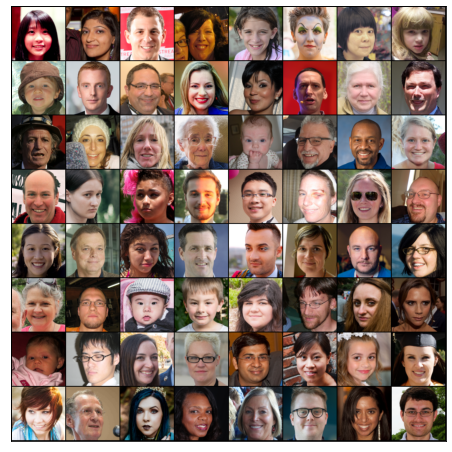

In [ ]:
images = torch.stack([train_dataset[i][0] for i in range(64)])
show_images(images)

# GAN

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.discriminator(x)

## Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.generator(x)

## GAN

In [8]:
class GAN(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.latent_size = latent_size
        self.discriminator = Discriminator()
        self.generator = Generator(latent_size)

    def forward(self, x):
        return self.generator(x)

In [9]:
def visualize_model(model):
    latent_code = torch.randn((16, latent_size, 1, 1)).to(device)
    fake_images = model.generator(latent_code)
    show_images(fake_images, 4, 4)

# Training

In [ ]:
def train(
    model,
    criterions,
    train_dataset,
    num_epochs,
    batch_size,
    lr=2e-4,
    scheduler=False,
    step_size=(1, 1),
    gammas=(0.1, 0.1),
):
    model.train()

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)

    optimizers = {
        "discriminator": optim.Adam(model.discriminator.parameters(), lr=lr, betas=(0.5, 0.999)),
        "generator": optim.Adam(model.generator.parameters(), lr=lr, betas=(0.5, 0.999)),
    }

    if scheduler:
        schedulers = {
            "discriminator": lr_scheduler.StepLR(optimizers["discriminator"], step_size[0], gammas[0]),
            "generator": lr_scheduler.StepLR(optimizers["discriminator"], step_size[1], gammas[1]),
        }

    d_loss = []
    g_loss = []

    fake_score = []
    real_score = []

    output_display = display.display("Collecting data for plot...", display_id=True)
    fig, (loss_ax, score_ax) = plt.subplots(1, 2, figsize=(15, 8))

    for epoch in tqdm(range(num_epochs), desc="epoch"):

        d_epoch_loss = 0
        g_epoch_loss = 0

        fake_epoch_score = 0
        real_epoch_score = 0

        for real_images, _ in tqdm(train_loader, desc="batch"):
            real_images = real_images.to(device)

            # train discriminator

            optimizers["discriminator"].zero_grad()

            latent = torch.randn((real_images.shape[0], model.latent_size, 1, 1), device=device)
            fake_images = model.generator(latent)

            real_preds = model.discriminator(real_images)
            fake_preds = model.discriminator(fake_images)

            real_batch_loss = criterions["discriminator"](
                real_preds, torch.ones((real_images.shape[0], 1), device=device)
            )
            fake_batch_loss = criterions["discriminator"](
                fake_preds, torch.zeros((real_images.shape[0], 1), device=device)
            )

            d_batch_loss = real_batch_loss + fake_batch_loss
            d_batch_loss.backward()
            optimizers["discriminator"].step()

            fake_epoch_score += fake_preds.mean().item()
            real_epoch_score += real_preds.mean().item()

            d_epoch_loss += d_batch_loss.item()

            # train generator

            optimizers["generator"].zero_grad()

            latent = torch.randn((real_images.shape[0], model.latent_size, 1, 1), device=device)
            fake_images = model.generator(latent)

            fake_preds = model.discriminator(fake_images)

            g_batch_loss = criterions["generator"](fake_preds, torch.ones((fake_images.shape[0], 1), device=device))
            g_batch_loss.backward()
            optimizers["generator"].step()

            g_epoch_loss += g_batch_loss.item()

        d_epoch_loss /= len(train_loader)
        g_epoch_loss /= len(train_loader)

        fake_epoch_score /= len(train_loader)
        real_epoch_score /= len(train_loader)

        print(
            f"d_loss: {d_epoch_loss} g_loss: {g_epoch_loss} real_score: {real_epoch_score} fake_score: {fake_epoch_score}"
        )

        d_loss.append(d_epoch_loss)
        g_loss.append(g_epoch_loss)

        fake_score.append(fake_epoch_score)
        real_score.append(real_epoch_score)

        if scheduler:
            schedulers["discriminator"].step()
            schedulers["generator"].step()

        loss_ax.clear()
        score_ax.clear()

        loss_ax.plot(d_loss, label="discriminator")
        loss_ax.plot(g_loss, label="generator")
        loss_ax.set_xlim(0, num_epochs)
        loss_ax.set_ylim(0)
        loss_ax.set_xlabel("epoch")
        loss_ax.set_ylabel("loss")
        loss_ax.legend()

        score_ax.plot(fake_score, label="fake")
        score_ax.plot(real_score, label="real")
        score_ax.set_xlim(0, num_epochs)
        score_ax.set_ylim(-0.1, 1.1)
        score_ax.set_xlabel("epoch")
        score_ax.set_ylabel("score")
        score_ax.legend()

        if epoch > 1:
            output_display.update(fig)

    plt.close(fig)

    return d_loss, g_loss, real_score, fake_score

In [10]:
latent_size = 128
gan = GAN(latent_size).to(device)
criterions = {"discriminator": nn.BCELoss(), "generator": nn.BCELoss()}

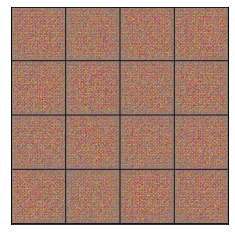

In [ ]:
visualize_model(gan)

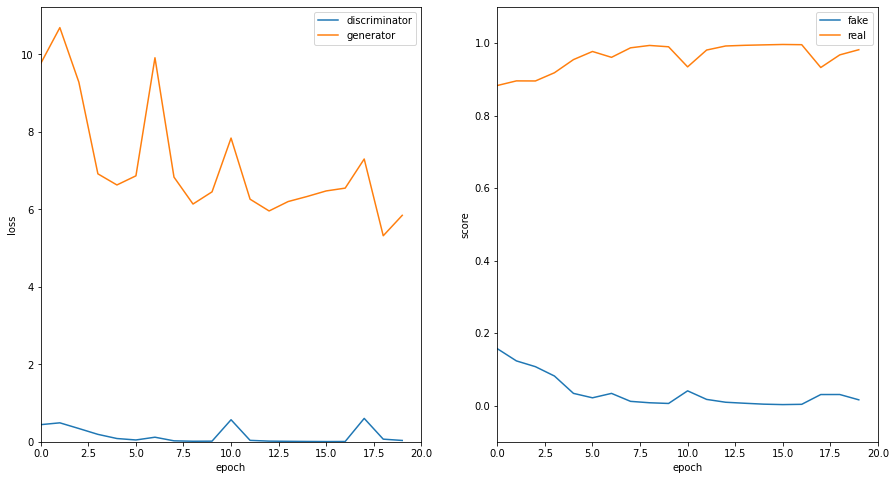

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.44292042501270773 g_loss: 9.769250860214234 real_score: 0.8831724238395691 fake_score: 0.15683241727008862


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.4895861813426018 g_loss: 10.6912273311615 real_score: 0.8958851528167725 fake_score: 0.12323406558619013


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.3427120605297387 g_loss: 9.282254066467285 real_score: 0.8956858706474304 fake_score: 0.10729831132322715


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.1921194616705179 g_loss: 6.916705894470215 real_score: 0.918358724117279 fake_score: 0.08151914125774055


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.08466648600995541 g_loss: 6.6297809553146365 real_score: 0.9546146476268769 fake_score: 0.033620274318382146


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.04730974117293954 g_loss: 6.865558648109436 real_score: 0.9770325124263763 fake_score: 0.021411777070652532


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.11837101048789918 g_loss: 9.913289995193482 real_score: 0.9608938533067704 fake_score: 0.03357588600151401


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.02499905224889517 g_loss: 6.832038822174073 real_score: 0.9871396470069885 fake_score: 0.011596964748823666


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.0141803967859596 g_loss: 6.13742205619812 real_score: 0.9936847686767578 fake_score: 0.007718953569419682


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.01649714439176023 g_loss: 6.451716051101685 real_score: 0.9899932682514191 fake_score: 0.005795032035093755


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.569340032665059 g_loss: 7.840139617919922 real_score: 0.9345708605885739 fake_score: 0.040614816113232595


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.037018649205565454 g_loss: 6.262273664474487 real_score: 0.981023998260498 fake_score: 0.016973062716424465


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.017221731208264826 g_loss: 5.9588091182708744 real_score: 0.9921952056884765 fake_score: 0.009149859771132468


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.012377430945634841 g_loss: 6.201319465637207 real_score: 0.9940843760967255 fake_score: 0.006359607256017625


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.008656495325267315 g_loss: 6.332387008666992 real_score: 0.9952673351764679 fake_score: 0.003850593729875982


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.00634256268851459 g_loss: 6.475514116287232 real_score: 0.9963653814792633 fake_score: 0.0026639486162457616


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.007730151396244765 g_loss: 6.548161220550537 real_score: 0.9957604074478149 fake_score: 0.003434224103111774


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.6038916056416929 g_loss: 7.299765380267054 real_score: 0.9328039420869936 fake_score: 0.030425077699159347


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.0682610423117876 g_loss: 5.318378686904907 real_score: 0.9676792335510254 fake_score: 0.03048323579132557


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.03476954389363527 g_loss: 5.845993270874024 real_score: 0.9819172072410584 fake_score: 0.01582818403840065


In [ ]:
d_loss, g_loss, real_score, fake_score = train(gan, criterions, train_dataset, 20, 64)

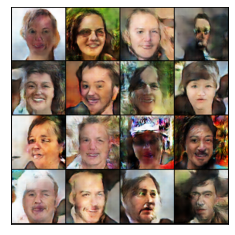

In [ ]:
visualize_model(gan)

Это, конечно, не идеал, но и не так плохо на мой взгляд. Если погенерировать изображения несколько раз, то можно найти весьма неплохие лица.

In [ ]:
torch.save(gan.state_dict(), "/content/drive/MyDrive/Models/gan_8.pt")

In [11]:
gan.load_state_dict(torch.load("/content/drive/MyDrive/Models/gan_8.pt", map_location=device))

<All keys matched successfully>

# Leave-One-Out 1-NN classifier accuracy

In [12]:
latent = torch.randn((len(train_dataset), latent_size, 1, 1)).to(device)
with torch.no_grad():
    fake_images = denormalize(gan(latent).detach().cpu(), 0.5, 0.5).permute(0, 2, 3, 1)

real_images = next(iter(DataLoader(train_dataset, len(train_dataset))))[0].permute(0, 2, 3, 1)

In [13]:
train_images = torch.cat((fake_images, real_images))
train_labels = torch.cat(
    (
        torch.zeros(
            fake_images.shape[0],
        ),
        torch.ones(real_images.shape[0]),
    )
)

perm_idxs = torch.randperm(train_images.shape[0])

train_images = train_images[perm_idxs].reshape(train_images.shape[0], -1)
train_labels = train_labels[perm_idxs].reshape(
    train_labels.shape[0],
)

In [ ]:
loo = LeaveOneOut()

real_acc = 0
fake_acc = 0
mean_acc = 0

real_n = 0
fake_n = 0

for train_index, test_index in tqdm(
    loo.split(train_images), total=loo.get_n_splits(train_images), leave=False, desc="n"
):
    X_train, X_test = train_images[train_index], train_images[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]

    classifier = KNeighborsClassifier(1)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict_proba(X_test)[0]

    if y_test:
        real_acc += y_pred[1]
        real_n += 1
    else:
        fake_acc += y_pred[0]
        fake_n += 1

    mean_acc += classifier.score(X_test, y_test)

real_acc /= real_n
fake_acc /= fake_n
mean_acc /= train_images.shape[0]

In [24]:
print(f"real_acc: {real_acc}, fake_acc: {fake_acc}, mean_acc: {mean_acc}")

real_acc: 0.8594704684317719, fake_acc: 1.0, mean_acc: 0.931


Видим, что классификатор смог полностью отличить искусственно созданные изображеня от настоящих, но при этом примерно в 15 процентах случаев ошибся, определяя настоящие изображения как фейковые. Это значит, что ни одно созданное изображение не сравнимо с настоящим, а вот настоящие порой похожи на фейковые (например, смазаны). Результат не очень удовлетворительный, на обоих метриках (real_acc, fake_acc) мы бы хотели видеть 0.5, это бы значило, что наш классификатор не может отличить созданные фотографии от настоящих (чего мы и добиваемся).

In [15]:
images_repr = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(train_images[:2000])
real_repr = images_repr[train_labels[:2000].numpy().astype(bool)]
fake_repr = images_repr[(1 - train_labels[:2000].numpy()).astype(bool)]

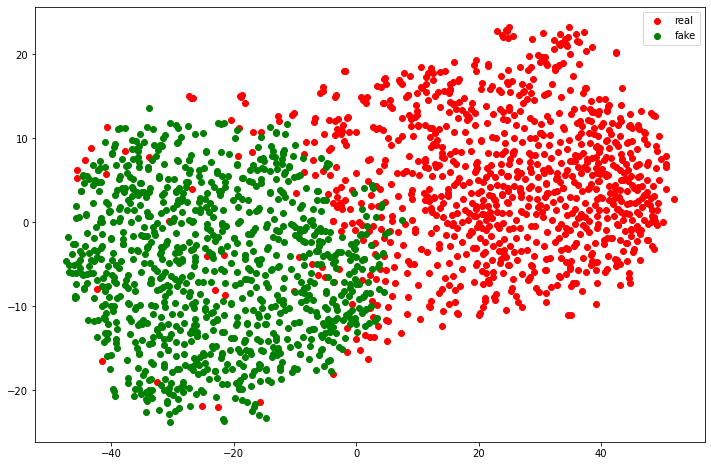

In [16]:
plt.figure(figsize=(12, 8))
colors = ["green", "red"]
plt.scatter(real_repr[:, 0], real_repr[:, 1], c="red", label="real")
plt.scatter(fake_repr[:, 0], fake_repr[:, 1], c="green", label="fake")
plt.legend()
plt.show()

Видим, что распределения +- совпадают с результатами, полученными выше - изображения хорошо классифицируемы, а некоторые точки реальных изображений лежат в множестве точек фейковых фотографий, в то время как точки фейковых фотографий не так сильно выходят за пределы своего распределения.